# Implementation: Collect Process Data


In [50]:
!pip install psutil pandas scikit-learn joblib stable-baselines3 gymnasium

In [4]:

import psutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from queue import Queue
import time
import threading
import os


In [9]:

def get_process_data():
    process_list = []
    
    for proc in psutil.process_iter(['pid', 'cpu_times', 'memory_info', 'nice']):
        try:
            info = proc.info
            process_list.append({
                "pid": info['pid'],
                "utime": info['cpu_times'].user if info['cpu_times'] else 0,  
                "stime": info['cpu_times'].system if info['cpu_times'] else 0, 
                "priority": info['nice'],  
                "mem_usage": info['memory_info'].rss if info['memory_info'] else 0  
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            continue
    
    return pd.DataFrame(process_list)


df = get_process_data()
df["process_type"] = df["utime"] > df["stime"] 
df.to_csv("windows_process_data.csv", index=False)
df.head()


pid  utime  stime  priority  mem_usage  process_type
0    0    0.0    0.0         0          0         False
1    1    0.0    0.0         0          0         False
2  505    0.0    0.0         0          0         False
3  506    0.0    0.0         0          0         False
4  507    0.0    0.0         0          0         False

In [8]:
# 📌 Step 4: Train an AI Model for Process Classification


X = df[["utime", "stime", "priority", "mem_usage"]]
y = df["process_type"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)


joblib.dump(model, "process_classifier.pkl")

print("✅ Model trained and saved as process_classifier.pkl")


✅ Model trained and saved as process_classifier.pkl


In [7]:
df.head()

pid  utime  stime  priority  mem_usage  process_type
0    0    0.0    0.0         0          0         False
1    1    0.0    0.0         0          0         False
2  505    0.0    0.0         0          0         False
3  506    0.0    0.0         0          0         False
4  507    0.0    0.0         0          0         False

# REINFORCEMENT LEARNING FOR INTERNAL QUEUE LOGIC

In [72]:
import threading
import time
import csv
import psutil
import pandas as pd
import joblib
import numpy as np
from queue import Queue
from stable_baselines3 import PPO

# Load trained RL model
rl_model = PPO.load("rl_scheduler_model.zip")
model = joblib.load("process_classifier.pkl")  # ML model for classification

# Define Queues
cpu_queue = Queue()
io_queue = Queue()
processed_pids = set()
running = True
last_action = None

# RL Metrics Dictionary
rl_metrics = {
    "decision_steps": 0,
    "total_reward": 0,
    "action_counts": {"PROCESS_CPU": 0, "PROCESS_IO": 0},
    "completed_tasks": {"CPU": 0, "IO": 0}
}
count = 0
def rl_decision(state):
    global count
    state_array = np.array([state['CPU_QUEUE_SIZE'], state['IO_QUEUE_SIZE']], dtype=np.float32).reshape(1, -1)
    action, _ = rl_model.predict(state_array, deterministic=True) 
    if count == 3:
        count = 0
        return 'PROCESS_IO'
    elif action == 0:
        count+=1
        return 'PROCESS_CPU'
    else:
        'PROCESS_IO'

def classify_and_enqueue():
    global processed_pids, running
    while running:
        for proc in psutil.process_iter(['pid']):
            if not running:
                break
            try:
                pid = proc.info['pid']
                if pid in processed_pids:
                    continue
                process_data = pd.DataFrame([{
                    "utime": proc.cpu_times().user if proc.cpu_times() else 0,
                    "stime": proc.cpu_times().system if proc.cpu_times() else 0,
                    "priority": proc.nice(),
                    "mem_usage": proc.memory_info().rss if proc.memory_info() else 0
                }])
                prediction = model.predict(process_data)[0]
                if prediction:
                    cpu_queue.put(pid)
                else:
                    io_queue.put(pid)
                processed_pids.add(pid)
            except (psutil.NoSuchProcess, psutil.AccessDenied):
                continue
        time.sleep(5)

def process_queue(q, queue_type, execution_time=2):
    global processed_pids, running
    while running:
        if not q.empty():
            pid = q.get()
            if not psutil.pid_exists(pid):
                continue
            print(f"Processing {queue_type} task: PID {pid}")
            time.sleep(execution_time)
            processed_pids.discard(pid)
            q.task_done()
            print(f"Completed {queue_type} task: PID {pid}")

def get_reward(state, last_action):
    cpu_load = psutil.cpu_percent(interval=1)
    io_load = psutil.disk_io_counters().read_bytes
    reward = 0
    if last_action == "PROCESS_CPU":
        reward += 10 if cpu_load < 50 else -10
        reward += 5 if state['CPU_QUEUE_SIZE'] < 50 else -5
    if last_action == "PROCESS_IO":
        reward += 15 if io_load < 500000 else -10
        reward += 5 if state['IO_QUEUE_SIZE'] < 30 else -5
    return reward

def update_rl_metrics(action, reward):
    rl_metrics["total_reward"] += reward
    rl_metrics["decision_steps"] += 1
    rl_metrics["action_counts"][action] += 1

def schedule_and_manage_queues():
    global running, last_action
    while running:
        state = {
            'CPU_QUEUE_SIZE': cpu_queue.qsize(),
            'IO_QUEUE_SIZE': io_queue.qsize()
        }
        action = rl_decision(state)
        if action == 'PROCESS_CPU' and not cpu_queue.empty():
            pid = cpu_queue.get()
            print(f"RL Action: Processing CPU task with PID {pid}")
            time.sleep(0.2)
            cpu_queue.task_done()
            reward = get_reward(state, last_action)
            update_rl_metrics("PROCESS_CPU", reward)
            last_action = 'PROCESS_CPU'
        elif action == 'PROCESS_IO' and not io_queue.empty():
            pid = io_queue.get()
            print(f"RL Action: Processing I/O task with PID {pid}")
            time.sleep(0.1)
            io_queue.task_done()
            reward = get_reward(state, last_action)
            update_rl_metrics("PROCESS_IO", reward)
            last_action = 'PROCESS_IO'
        time.sleep(0.2)

def log_rl_metrics():
    with open("rl_metrics_log.csv", "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Time", "Steps", "PROCESS_CPU", "PROCESS_IO", "Total Reward", "Avg Reward", "CPU Queue", "IO Queue"])
    while running:
        avg_reward = rl_metrics["total_reward"] / rl_metrics["decision_steps"] if rl_metrics["decision_steps"] > 0 else 0
        with open("rl_metrics_log.csv", "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                time.strftime("%H:%M:%S"), rl_metrics["decision_steps"], 
                rl_metrics["action_counts"]["PROCESS_CPU"], 
                rl_metrics["action_counts"]["PROCESS_IO"],
                rl_metrics["total_reward"], avg_reward,
                cpu_queue.qsize(), io_queue.qsize()
            ])
        time.sleep(5)

cpu_worker = threading.Thread(target=process_queue, args=(cpu_queue, "CPU-bound", 2), daemon=True)
io_worker = threading.Thread(target=process_queue, args=(io_queue, "I/O-bound", 1), daemon=True)
classifier_thread = threading.Thread(target=classify_and_enqueue, daemon=True)
scheduler_thread = threading.Thread(target=schedule_and_manage_queues, daemon=True)
log_metrics_thread = threading.Thread(target=log_rl_metrics, daemon=True)

cpu_worker.start()
io_worker.start()
classifier_thread.start()
scheduler_thread.start()
log_metrics_thread.start()

try:
    while True:
        print(f"CPU Queue Size: {cpu_queue.qsize()} | IO Queue Size: {io_queue.qsize()}")
        time.sleep(5)
except KeyboardInterrupt:
    print("\nStopping program...")
    running = False
    classifier_thread.join()
    cpu_worker.join()
    io_worker.join()
    scheduler_thread.join()
    log_metrics_thread.join()
    print("All threads stopped.")


CPU Queue Size: 0 | IO Queue Size: 0
Processing CPU-bound task: PID 577
Processing I/O-bound task: PID 824
RL Action: Processing CPU task with PID 804
Completed I/O-bound task: PID 824
Processing I/O-bound task: PID 835
RL Action: Processing CPU task with PID 805
Completed CPU-bound task: PID 577
Processing CPU-bound task: PID 810
Completed I/O-bound task: PID 835
Processing I/O-bound task: PID 843
Completed I/O-bound task: PID 843
Processing I/O-bound task: PID 844
RL Action: Processing CPU task with PID 811
Completed CPU-bound task: PID 810
Processing CPU-bound task: PID 814
Completed I/O-bound task: PID 844
Processing I/O-bound task: PID 857
RL Action: Processing I/O task with PID 861
CPU Queue Size: 434 | IO Queue Size: 58
Completed I/O-bound task: PID 857
Processing I/O-bound task: PID 873
RL Action: Processing CPU task with PID 816
Completed CPU-bound task: PID 814
Processing CPU-bound task: PID 817
Completed I/O-bound task: PID 873
Processing I/O-bound task: PID 877
Completed I/

In [59]:
import gymnasium as gym
from stable_baselines3 import PPO
from process_scheduler import ProcessSchedulingEnv  # Import your custom environment


env = ProcessSchedulingEnv()


model = PPO("MlpPolicy", env, learning_rate=0.001, verbose=1)


model.learn(total_timesteps=100000)

model.save("rl_scheduler_model")

print("Model saved as rl_scheduler_model.zip")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.1     |
|    ep_rew_mean     | -339     |
| time/              |          |
|    fps             | 6732     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.2        |
|    ep_rew_mean          | -248        |
| time/                   |             |
|    fps                  | 4836        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017851986 |
|    clip_fraction        | 0.318       |
|    clip_range           | 0.2         |
|    entropy_loss   

In [53]:
import threading
import time
import csv
import psutil
import pandas as pd
import joblib
from queue import Queue

# Load trained ML model
model = joblib.load("process_classifier.pkl")

# Define Queues
cpu_queue = Queue()
io_queue = Queue()
processed_pids = set()
running = True  


# RL-related variables
state_space = ['CPU_QUEUE_SIZE', 'IO_QUEUE_SIZE']
action_space = ['PROCESS_CPU', 'PROCESS_IO']
count = 0 
last_action = None
# RL Metrics Dictionary
rl_metrics = {
    "decision_steps": 0,
    "total_reward": 0,
    "action_counts": {"PROCESS_CPU": 0, "PROCESS_IO": 0},
    "completed_tasks": {"CPU": 0, "IO": 0}
}

# Placeholder function for RL agent's decision-making
def rl_decision(state):
    global count
    if count == 3:
        count = 0
        return 'PROCESS_IO'
    elif state['CPU_QUEUE_SIZE'] > state['IO_QUEUE_SIZE']:
        count += 1
        return 'PROCESS_CPU'
    else:
        return 'PROCESS_IO'

# Classify and enqueue processes
def classify_and_enqueue():
    global processed_pids, running
    while running:
        for proc in psutil.process_iter(['pid']):
            if not running:
                break
            try:
                pid = proc.info['pid']
                if pid in processed_pids:
                    continue

                
                process_data = pd.DataFrame([{
                    "utime": proc.cpu_times().user if proc.cpu_times() else 0,
                    "stime": proc.cpu_times().system if proc.cpu_times() else 0,
                    "priority": proc.nice(),
                    "mem_usage": proc.memory_info().rss if proc.memory_info() else 0
                }])

                
                prediction = model.predict(process_data)[0]

                
                if prediction:
                    cpu_queue.put(pid)
                else:
                    io_queue.put(pid)

                processed_pids.add(pid)  
            except (psutil.NoSuchProcess, psutil.AccessDenied):
                continue
        time.sleep(5)


def process_queue(q, queue_type, execution_time=2):
    global processed_pids, running
    while running:
        if not q.empty():
            pid = q.get()
            if not psutil.pid_exists(pid):
                print(f"Skipping {queue_type} task (PID {pid} no longer exists)")
                continue

            print(f"Processing {queue_type} task: PID {pid}")
            time.sleep(execution_time)
            processed_pids.discard(pid)
            q.task_done()
            print(f"Completed {queue_type} task: PID {pid}")
        else:
            time.sleep(1)


def get_reward(state, last_action):
    reward = 0

   
    if last_action == "PROCESS_CPU":
        reward += 10  
        if state['CPU_QUEUE_SIZE'] > 100:  
            reward += 10  
        if state['CPU_QUEUE_SIZE'] > 500:  
            reward += 20 
        if state['IO_QUEUE_SIZE'] < 20:  
            reward += 5  
    
    
    if last_action == "PROCESS_IO":
        reward += 15  
        if state['IO_QUEUE_SIZE'] > 20:
            reward += 10  
        if state['IO_QUEUE_SIZE'] > 50:
            reward += 20  

    
    if state['CPU_QUEUE_SIZE'] > 500:
        reward -= 5 
    
   
    if state['IO_QUEUE_SIZE'] > 50:
        reward -= 15  

    return reward

# RL Scheduling and Queue Management
def schedule_and_manage_queues():
    global running
    global last_action
    while running:
        state = {
            'CPU_QUEUE_SIZE': cpu_queue.qsize(),
            'IO_QUEUE_SIZE': io_queue.qsize()
        }

        action = rl_decision(state)
        
        if action == 'PROCESS_CPU' and not cpu_queue.empty():
            pid = cpu_queue.get()
            print(f"RL Action: Processing CPU task with PID {pid}")
            time.sleep(2)
            cpu_queue.task_done()
            reward = get_reward(state,last_action)
            rl_metrics["total_reward"] += reward
            rl_metrics["decision_steps"] += 1
            rl_metrics["action_counts"]["PROCESS_CPU"] += 1
            rl_metrics["completed_tasks"]["CPU"] += 1
            last_action = 'PROCESS_CPU'

        elif action == 'PROCESS_IO' and not io_queue.empty():
            pid = io_queue.get()
            print(f"RL Action: Processing I/O task with PID {pid}")
            time.sleep(1)
            io_queue.task_done()
            reward = get_reward(state,last_action)
            rl_metrics["total_reward"] += reward
            rl_metrics["decision_steps"] += 1
            rl_metrics["action_counts"]["PROCESS_IO"] += 1
            rl_metrics["completed_tasks"]["IO"] += 1
            last_action = 'PROCESS_IO'

        time.sleep(1)


def log_rl_metrics():
    """ Periodically logs RL agent metrics into a CSV file """
    with open("rl_metrics_log.csv", "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Time", "Steps", "PROCESS_CPU", "PROCESS_IO", "Total Reward", "Avg Reward", "CPU Queue", "IO Queue"])

    while running:
        print("Logging metrics...") 

        if rl_metrics["decision_steps"] > 0:
            avg_reward = rl_metrics["total_reward"] / rl_metrics["decision_steps"]
        else:
            avg_reward = 0

        with open("rl_metrics_log.csv", "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                time.strftime("%H:%M:%S"), rl_metrics["decision_steps"], 
                rl_metrics["action_counts"]["PROCESS_CPU"], 
                rl_metrics["action_counts"]["PROCESS_IO"],
                rl_metrics["total_reward"], avg_reward,
                cpu_queue.qsize(), io_queue.qsize()
            ])
            file.flush()  

        time.sleep(5) 

# Start Worker Threads
cpu_worker = threading.Thread(target=process_queue, args=(cpu_queue, "CPU-bound", 2), daemon=True)
io_worker = threading.Thread(target=process_queue, args=(io_queue, "I/O-bound", 1), daemon=True)
classifier_thread = threading.Thread(target=classify_and_enqueue, daemon=True)
scheduler_thread = threading.Thread(target=schedule_and_manage_queues, daemon=True)
log_metrics_thread = threading.Thread(target=log_rl_metrics, daemon=True)  # Logging thread

# Start all threads
cpu_worker.start()
io_worker.start()
classifier_thread.start()
scheduler_thread.start()
log_metrics_thread.start()


try:
    while True:
        print(f"CPU Queue Size: {cpu_queue.qsize()} | IO Queue Size: {io_queue.qsize()}")
        time.sleep(5)
except KeyboardInterrupt:
    print("\nStopping program...")
    running = False 
    classifier_thread.join()
    cpu_worker.join()
    io_worker.join()
    scheduler_thread.join()
    log_metrics_thread.join()
    print("All threads stopped.")



✅ RL Model Loaded Successfully!
CPU Queue Size: 0 | IO Queue Size: 0
Logging metrics...
Processing CPU-bound task: PID 577Processing I/O-bound task: PID 824

RL Action: Processing CPU task with PID 804
Completed I/O-bound task: PID 824
Processing I/O-bound task: PID 835

Stopping program...
Completed I/O-bound task: PID 835
Completed CPU-bound task: PID 577
All threads stopped.


## Perform metrics 


In [7]:
import psutil
import pandas as pd

def get_windows_process_data():
    """ Collects process data from Windows for evaluation. """
    process_list = []
    
    for proc in psutil.process_iter(attrs=['pid', 'cpu_times', 'memory_info', 'nice']):
        try:
            info = proc.info
            process_list.append({
                "pid": info['pid'],
                "utime": info['cpu_times'].user if info['cpu_times'] else 0,  # User mode CPU time
                "stime": info['cpu_times'].system if info['cpu_times'] else 0,  # Kernel mode CPU time
                "priority": info['nice'],  # Process priority
                "mem_usage": info['memory_info'].rss if info['memory_info'] else 0  # Memory usage in bytes
            })
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            continue

    return pd.DataFrame(process_list)

# Get real-time Windows process data
df_test = get_windows_process_data()
df_test.to_csv("windows_test_data2.csv", index=False)  # Save for reuse


In [8]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


model = joblib.load("process_classifier.pkl")


df_test = pd.read_csv("windows_process_data.csv")


X_test = df_test.drop(columns=["pid"])



In [9]:
y_pred = model.predict(X_test)
df_test["predicted_class"] = y_pred
print(df_test.head())  


   pid  utime  stime  priority  mem_usage  predicted_class
0    0    0.0    0.0         0          0            False
1    1    0.0    0.0         0          0            False
2  505    0.0    0.0         0          0            False
3  506    0.0    0.0         0          0            False
4  507    0.0    0.0         0          0            False


In [31]:

df_test["true_label"] = df_test.apply(lambda row: 1 if row["utime"] + row["stime"] > 0.5 else 0, axis=1)


y_test = df_test["true_label"]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


NameError: name 'df_test' is not defined

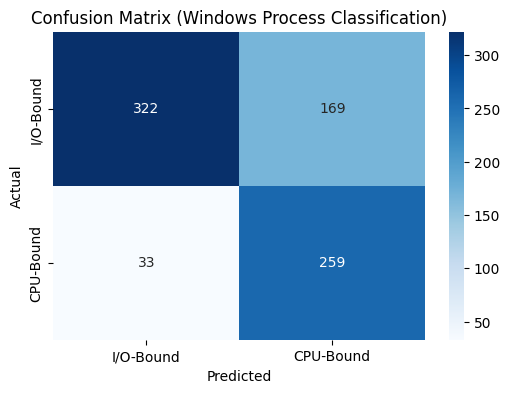

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["I/O-Bound", "CPU-Bound"], yticklabels=["I/O-Bound", "CPU-Bound"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Windows Process Classification)")
plt.show()


# DEBUGGING REQ

In [45]:
import pandas as pd

def evaluate_rl_agent(csv_file):
    """ Computes RL agent performance metrics from log data """
    
    df = pd.read_csv(csv_file)
    
    
    
    # Convert necessary columns to integers/floats
    int_cols = ["PROCESS_CPU", "PROCESS_IO", "Steps", "CPU Queue", "IO Queue"]
    float_cols = ["Avg Reward"]
    df[int_cols] = df[int_cols].astype(int)
    df[float_cols] = df[float_cols].astype(float)

    # Calculate key metrics
    total_actions = df["Steps"].sum() 
    cpu_actions = df["PROCESS_CPU"].sum()
    io_actions = df["PROCESS_IO"].sum()

    # Efficiency metrics
    cpu_utilization = (cpu_actions / total_actions) * 100 
    io_utilization = (io_actions / total_actions) * 100 

    # Queue balance ratio
    if len(df) >= 2:
        final_cpu_queue = df.iloc[-1:]["CPU Queue"].mean()
        final_io_queue = df.iloc[-1:]["IO Queue"].mean()
        queue_balance = final_cpu_queue / (final_io_queue + 1)  # Avoid division by zero
    else:
        queue_balance = None

    # Average Reward Analysis
    avg_reward = df["Avg Reward"].mean() if not df.empty else 0
    max_reward = df["Avg Reward"].max() if not df.empty else 0
    min_reward = df["Avg Reward"].min() if not df.empty else 0

    # Processing Rate (actions per time step)
    processing_rate = total_actions / len(df) if len(df) > 0 else 0

    # Display Results
    print(" RL Agent Evaluation Metrics:")
    print(f"Total Actions Taken: {total_actions}")
    print(f"CPU Actions Processed: {cpu_actions} ({cpu_utilization:.2f}%)")
    print(f"IO Actions Processed: {io_actions} ({io_utilization:.2f}%)")
    print(f"Queue Balance (CPU/IO Ratio): {queue_balance if queue_balance is not None else 'N/A'}")
    print(f"Average Reward: {avg_reward:.2f} (Min: {min_reward}, Max: {max_reward})")
    print(f"Processing Rate: {processing_rate:.2f} actions per step")




In [12]:
df = pd.read_csv("rl_metrics_log.csv")
df.columns

Index(['Time', 'Steps', 'PROCESS_CPU', 'PROCESS_IO', 'Total Reward',
       'Avg Reward', 'CPU Queue', 'IO Queue'],
      dtype='object')

In [21]:
df = pd.read_csv("rl_metrics_log.csv")
df.columns = df.columns.str.strip()  # Trim spaces from column names
print("🔍 CSV Head:\n", df.head())  # Inspect initial data

df = df.apply(pd.to_numeric, errors='coerce')  # Convert safely
print("🔍 Data Types:\n", df.dtypes)  # Check types

print("🔍 Steps Column Stats:\n", df["Steps"].describe())  # Check if Steps has meaningful values

df.fillna(0, inplace=True)  # Replace NaNs with zeros


🔍 CSV Head:
        Time  Steps  PROCESS_CPU  PROCESS_IO  Total Reward  Avg Reward  \
0  23:20:30      0            0           0             0    0.000000   
1  23:20:35      2            2           0             5    2.500000   
2  23:20:40      4            3           1            15    3.750000   
3  23:20:45      5            4           1            45    9.000000   
4  23:20:50      7            6           1            55    7.857143   

   CPU Queue  IO Queue  
0         27         3  
1        446        68  
2        446        67  
3        444        67  
4        443        66  
🔍 Data Types:
 Time            float64
Steps             int64
PROCESS_CPU       int64
PROCESS_IO        int64
Total Reward      int64
Avg Reward      float64
CPU Queue         int64
IO Queue          int64
dtype: object
🔍 Steps Column Stats:
 count    190.000000
mean     170.073684
std       98.081948
min        0.000000
25%       85.500000
50%      171.000000
75%      256.750000
max      331.0

In [34]:
total_actions = df["Steps"].sum() 
cpu_actions = df["PROCESS_CPU"].sum()
io_actions = df["PROCESS_IO"].sum()
cpu_utilization = (cpu_actions / total_actions) * 100
print(cpu_utilization)

75.96707309525283


In [46]:
evaluate_rl_agent("rl_metrics_log.csv")

🚀 RL Agent Evaluation Metrics:
🔹 Total Actions Taken: 32314
🔹 CPU Actions Processed: 24548 (75.97%)
🔹 IO Actions Processed: 7766 (24.03%)
🔹 Queue Balance (CPU/IO Ratio): 217.0
🔹 Average Reward: 15.38 (Min: 0.0, Max: 19.71299093655589)
🔹 Processing Rate: 170.07 actions per step


In [2]:
import psutil

def get_process_metrics(pid):
    try:
        p = psutil.Process(pid)
        with p.oneshot():
            return {
                "pid": pid,
                "cpu_percent": p.cpu_percent(interval=0.1),
                "mem_usage": p.memory_info().rss / (1024 * 1024),  # Convert to MB
                "io_read_bytes": p.io_counters().read_bytes,
                "io_write_bytes": p.io_counters().write_bytes,
                "voluntary_ctx_switches": p.num_ctx_switches().voluntary,
            }
    except psutil.AccessDenied:
        print(f"Permission denied for PID {pid}. Skipping...")
        return None
    except psutil.NoSuchProcess:
        return None

def main():
    for proc in psutil.process_iter(attrs=['pid']):
        metrics = get_process_metrics(proc.info['pid'])
        if metrics:
            print(metrics)

if __name__ == "__main__":
    main()


Permission denied for PID 0. Skipping...
Permission denied for PID 1. Skipping...
Permission denied for PID 505. Skipping...
Permission denied for PID 506. Skipping...
Permission denied for PID 507. Skipping...
Permission denied for PID 509. Skipping...
Permission denied for PID 510. Skipping...
Permission denied for PID 513. Skipping...
Permission denied for PID 516. Skipping...
Permission denied for PID 517. Skipping...
Permission denied for PID 518. Skipping...
Permission denied for PID 519. Skipping...
Permission denied for PID 521. Skipping...
Permission denied for PID 523. Skipping...
Permission denied for PID 525. Skipping...
Permission denied for PID 526. Skipping...
Permission denied for PID 528. Skipping...
Permission denied for PID 532. Skipping...
Permission denied for PID 533. Skipping...
Permission denied for PID 534. Skipping...
Permission denied for PID 535. Skipping...
Permission denied for PID 538. Skipping...
Permission denied for PID 539. Skipping...
Permission deni

AttributeError: 'Process' object has no attribute 'io_counters'